In [154]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Read data in and pre-propcessing (Subset, rename, merge)

In [155]:
House_Price = pd.read_csv('Data/HousePrice.csv')
Scores = pd.read_csv('Data/Scores.csv')

In [156]:
print(House_Price.shape[0])
print(Scores.shape[0])

4835
4835


In [157]:
Selected_Columns = ['Local authority code', 'LSOA code', 'LSOA name', 'Year ending Mar 2019',
                     'Year ending Jun 2019', 'Year ending Sep 2019', 'Year ending Dec 2019']

House_Price_2019 = House_Price[Selected_Columns]

House_Price_2019 = House_Price_2019.rename(columns={
    'Local authority code': 'Local_Authority_Code',
    'LSOA code': 'LSOA_Code',
    'LSOA name': 'LSOA_Name',
    'Year ending Mar 2019': 'Mar_2019',
    'Year ending Jun 2019': 'Jun_2019',
    'Year ending Sep 2019': 'Sep_2019',
    'Year ending Dec 2019': 'Dec_2019'
})

House_Price_2019['Mar_2019'] = pd.to_numeric(House_Price_2019['Mar_2019'].str.replace(',', ''), errors='coerce')
House_Price_2019['Jun_2019'] = pd.to_numeric(House_Price_2019['Jun_2019'].str.replace(',', ''), errors='coerce')
House_Price_2019['Sep_2019'] = pd.to_numeric(House_Price_2019['Sep_2019'].str.replace(',', ''), errors='coerce')
House_Price_2019['Dec_2019'] = pd.to_numeric(House_Price_2019['Dec_2019'].str.replace(',', ''), errors='coerce')

House_Price_2019['Year_2019'] = House_Price_2019[['Mar_2019', 'Jun_2019', 'Sep_2019', 'Dec_2019']].mean(axis=1, skipna=False).fillna(0)

House_Price_2019 = House_Price_2019[House_Price_2019['Year_2019']!=0]

In [158]:
Scores_Filtered = Scores[['LSOA code (2011)', 'Income Score (rate)', 'Education, Skills and Training Score', 'Crime Score', 'Barriers to Housing and Services Score', 'Living Environment Score']]

Scores_Filtered = Scores_Filtered.rename(columns={
    'LSOA code (2011)': 'LSOA_Code',
    'Income Score (rate)': 'Income_Score',
    'Education, Skills and Training Score': 'Education_Score',
    'Barriers to Housing and Services Score': 'Barriers_Score',
    'Crime Score': 'Crime_Score',
    'Living Environment Score': 'Living_Score'
})

In [159]:
Merged_df = pd.merge(House_Price_2019, Scores_Filtered, on='LSOA_Code')

In [160]:
print(Merged_df.shape[0])

4153


In [13]:
summary_statistics = Merged_df[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score', 'Year_2019']].describe()

print(summary_statistics)


       Income_Score  Education_Score  Crime_Score  Barriers_Score  \
count   4153.000000      4153.000000  4153.000000     4153.000000   
mean       0.122923        11.677558     0.221117       30.460583   
std        0.076152         9.296877     0.572137        9.412335   
min        0.000000         0.000000    -2.400000        6.900000   
25%        0.100000         4.300000    -0.200000       23.700000   
50%        0.100000         9.700000     0.200000       29.700000   
75%        0.200000        16.700000     0.600000       36.600000   
max        0.300000        57.200000     2.100000       65.000000   

       Living_Score     Year_2019  
count   4153.000000  4.153000e+03  
mean      29.217409  5.576917e+05  
std       11.149046  3.337318e+05  
min        5.500000  9.084375e+04  
25%       21.100000  3.779375e+05  
50%       28.500000  4.698750e+05  
75%       35.900000  6.187500e+05  
max       91.600000  4.900000e+06  


### Plot of distribution (Log transformation)

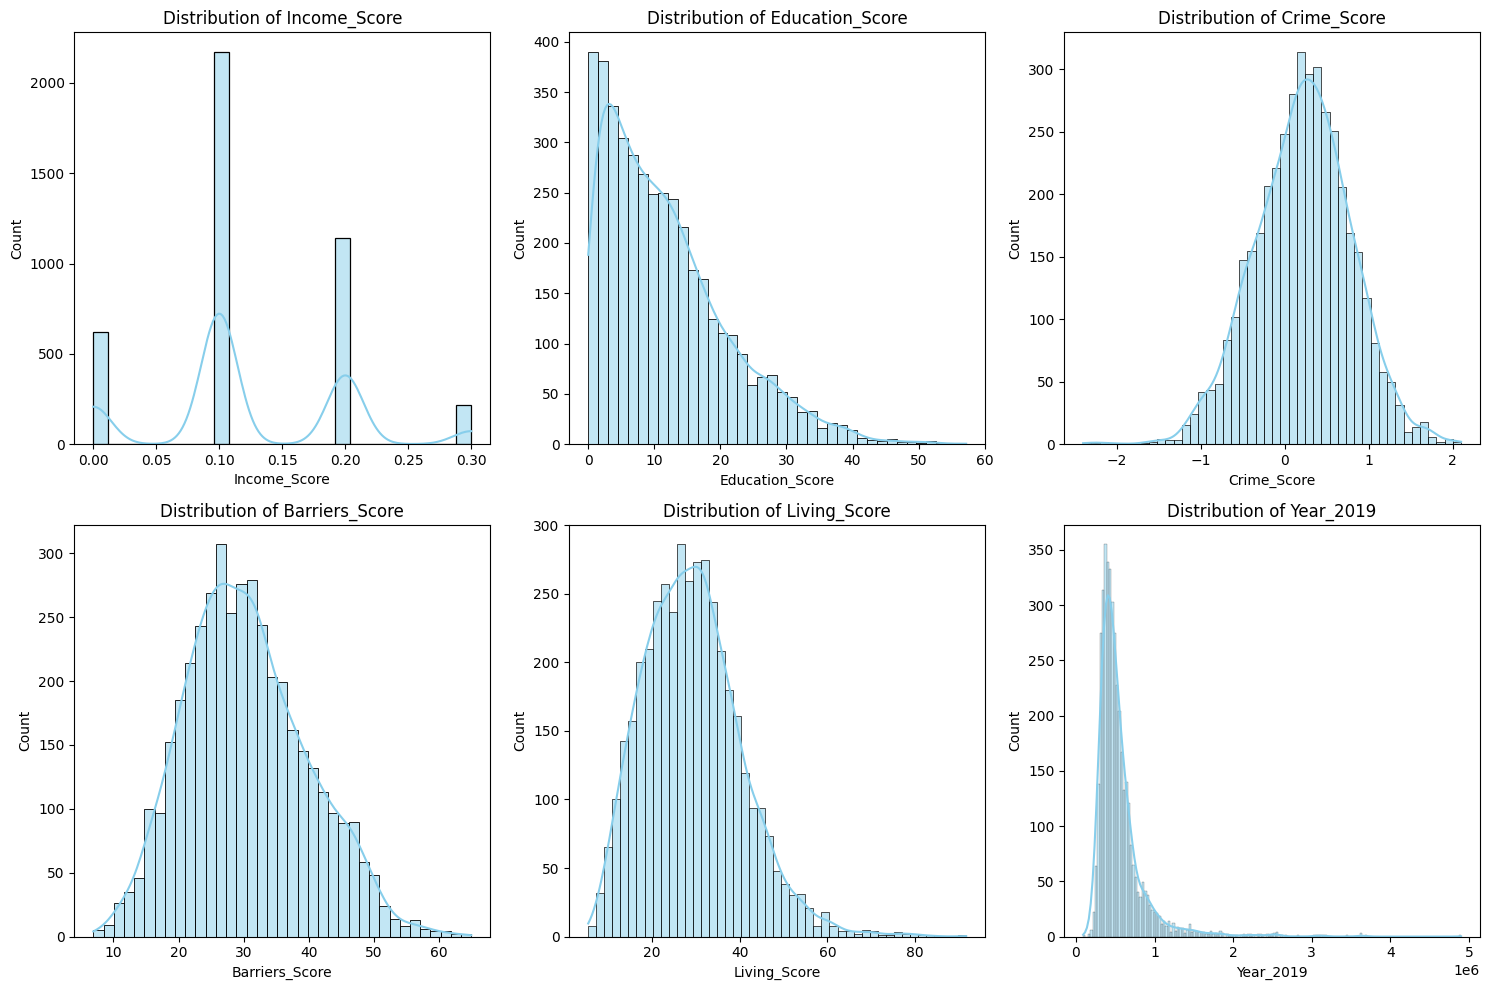

In [14]:
# 从 Merged_df 中提取需要的列
data_columns = ['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score', 'Year_2019']
data = Merged_df[data_columns]

# 创建包含六个子图的画布
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 将 axs 展平为一维数组，以便使用循环访问每个子图
axs = axs.flatten()

# 使用循环在每个子图中绘制直方图
for i in range(len(data_columns)):
    sns.histplot(data[data_columns[i]], ax=axs[i], kde=True, color='skyblue')
    axs[i].set_title(f'Distribution of {data_columns[i]}')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


In [161]:
Merged_df_log = Merged_df.copy()

Merged_df_log['Year_2019'] = np.log(Merged_df_log['Year_2019'])

Merged_df_log['Education_Score'] = Merged_df_log['Education_Score'] - Merged_df_log['Education_Score'].min() + 1
Merged_df_log['Education_Score'] = np.log(Merged_df_log['Education_Score'])

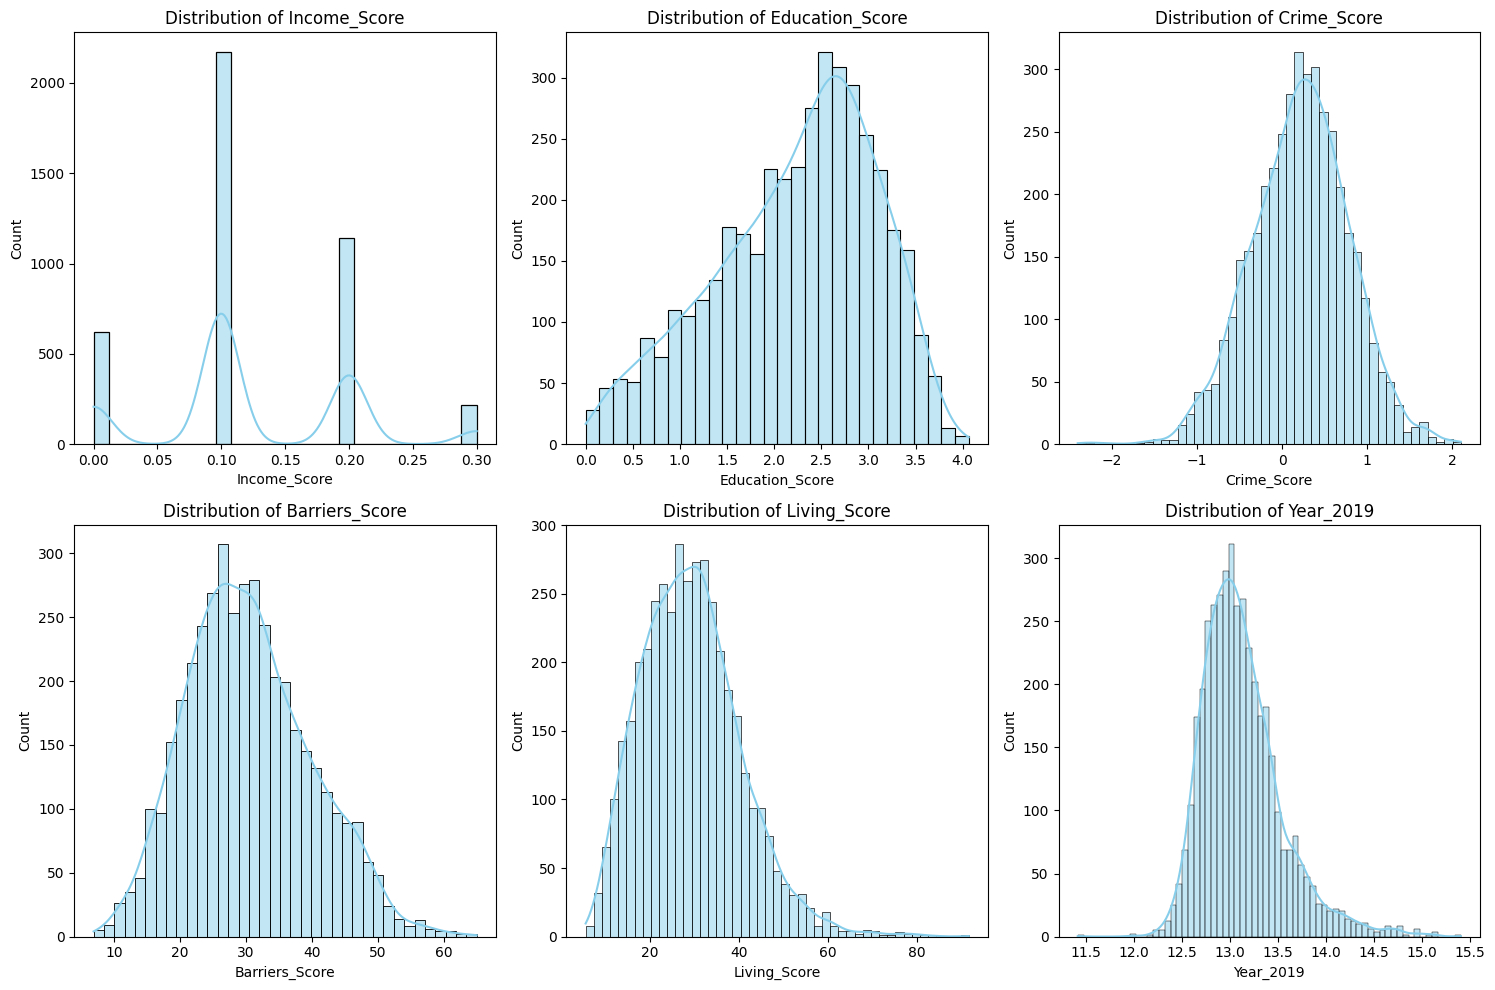

In [10]:
# 从 Merged_df 中提取需要的列
data_columns = ['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score', 'Year_2019']
data = Merged_df_log[data_columns]

# 创建包含六个子图的画布
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 将 axs 展平为一维数组，以便使用循环访问每个子图
axs = axs.flatten()

# 使用循环在每个子图中绘制直方图
for i in range(len(data_columns)):
    sns.histplot(data[data_columns[i]], ax=axs[i], kde=True, color='skyblue')
    axs[i].set_title(f'Distribution of {data_columns[i]}')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

### Multicollinearity check(VIF)

In [162]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [163]:
Merged_df_log_Filtered = Merged_df_log[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score', 'Year_2019']]

In [164]:
Merged_df_log_Filtered.columns

Index(['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score',
       'Living_Score', 'Year_2019'],
      dtype='object')

In [165]:
Merged_df_log_Filtered_after_VIF = drop_column_using_vif_(Merged_df_log_Filtered[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score']])

In [166]:
Merged_df_log_Filtered_after_VIF.columns

Index(['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score',
       'Living_Score'],
      dtype='object')

### Normalisation

In [167]:
# Create a MinMaxScaler
scaler = MinMaxScaler()

Merged_df_log_Filtered_after_VIF_Normalised = Merged_df_log_Filtered[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score', 'Year_2019']]

# Apply Min-Max scaling to the selected columns
Merged_df_log_Filtered_after_VIF_Normalised[['Year_2019']] = scaler.fit_transform(Merged_df_log_Filtered[['Year_2019']])

### Model1 with log, normalisation, VIF

In [28]:
X = sm.add_constant(Merged_df_log_Filtered_after_VIF_Normalised[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score']])
y = Merged_df_log_Filtered_after_VIF_Normalised['Year_2019']

model = sm.OLS(y, X).fit()

In [29]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Year_2019   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     684.7
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:45:08   Log-Likelihood:                 4739.0
No. Observations:                4153   AIC:                            -9466.
Df Residuals:                    4147   BIC:                            -9428.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5757      0.006     

In [ ]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(model.fittedvalues, model.resid, alpha = 0.5, s=20)
# plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted log London House Price in 2019')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of log London House Price in 2019')
# Adding grid lines
plt.grid(True)
plt.show()

In [ ]:
# Histogram of residuals

# Set the figure size
plt.figure(figsize=(8, 6))  

# Plotting the histogram
plt.hist(model.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of the Traffic Flow OLS Model')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

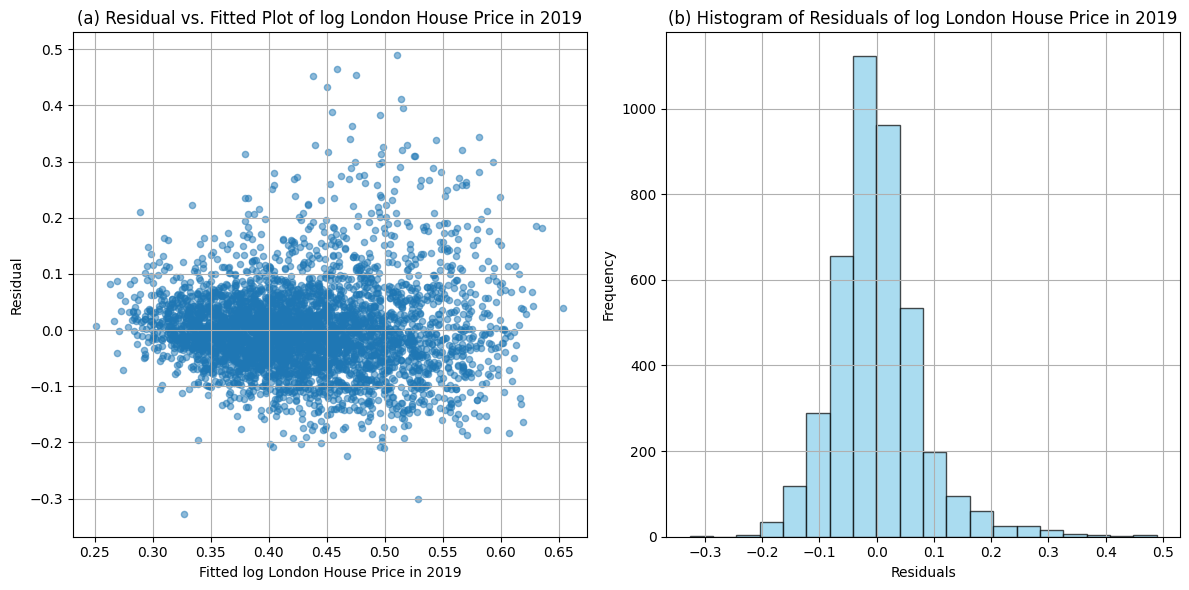

In [153]:
plt.figure(figsize=(12, 6))

# 图 A
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, model.resid, alpha = 0.5, s=20)
# plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted log London House Price in 2019')
plt.ylabel('Residual')
plt.title('(a) Residual vs. Fitted Plot of log London House Price in 2019')
# Adding grid lines
plt.grid(True)

# 图 B
plt.subplot(1, 2, 2)
# Plotting the histogram
plt.hist(model.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('(b) Histogram of Residuals of log London House Price in 2019')
# Adding grid lines (optional)
plt.grid(True)

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


### Model2 with normalisation and VIF

#### VIF

In [75]:
Merged_df_Withoutlog_Filtered = Merged_df[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score', 'Year_2019']]

Merged_df_Withoutlog_Filtered.columns

Index(['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score',
       'Living_Score', 'Year_2019'],
      dtype='object')

In [76]:
Merged_df_Withoutlog_Filtered_after_VIF = drop_column_using_vif_(Merged_df_Withoutlog_Filtered[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score']])

In [77]:
Merged_df_Withoutlog_Filtered_after_VIF.columns

Index(['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score',
       'Living_Score'],
      dtype='object')

#### Normalisation

In [78]:
# Create a MinMaxScaler
scaler = MinMaxScaler()

Merged_df_Withoutlog_Filtered_after_VIF_Normalised = Merged_df_Withoutlog_Filtered[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score', 'Year_2019']]

# Apply Min-Max scaling to the selected columns
Merged_df_Withoutlog_Filtered_after_VIF_Normalised[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score', 'Year_2019']] = scaler.fit_transform(Merged_df_Withoutlog_Filtered[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score', 'Year_2019']])

#### Model2

In [79]:
X2 = sm.add_constant(Merged_df_Withoutlog_Filtered_after_VIF_Normalised[['Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score']])
y2 = Merged_df_Withoutlog_Filtered_after_VIF_Normalised['Year_2019']

model2 = sm.OLS(y2, X2).fit()

In [80]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              Year_2019   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     282.5
Date:                Sun, 14 Jan 2024   Prob (F-statistic):          9.42e-261
Time:                        18:08:24   Log-Likelihood:                 5796.3
No. Observations:                4153   AIC:                        -1.158e+04
Df Residuals:                    4147   BIC:                        -1.154e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1206      0.005     

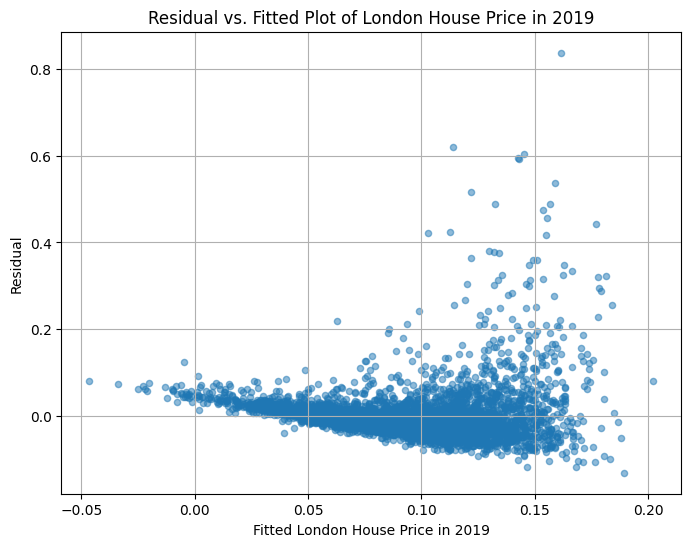

In [81]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(model2.fittedvalues, model2.resid, alpha = 0.5, s=20)
# plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted London House Price in 2019')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of London House Price in 2019')
# Adding grid lines
plt.grid(True)
plt.show()

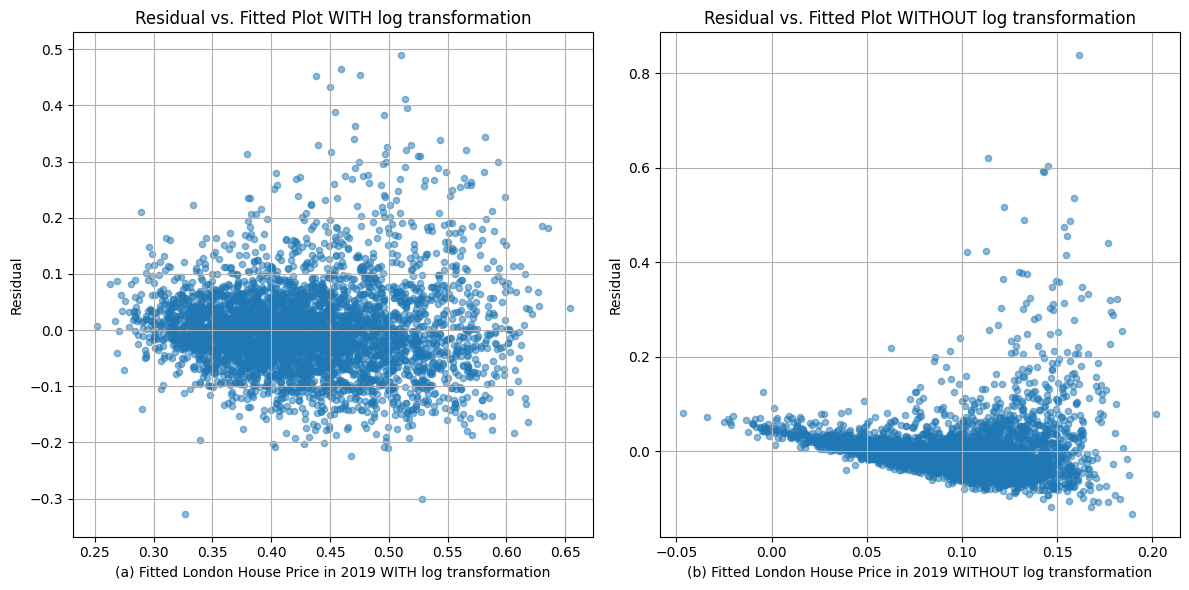

In [82]:
plt.figure(figsize=(12, 6))

# 图 A
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, model.resid, alpha=0.5, s=20)
plt.xlabel('(a) Fitted London House Price in 2019 WITH log transformation')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot WITH log transformation')
plt.grid(True)

# 图 B
plt.subplot(1, 2, 2)
plt.scatter(model2.fittedvalues, model2.resid, alpha=0.5, s=20)
plt.xlabel('(b) Fitted London House Price in 2019 WITHOUT log transformation')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot WITHOUT log transformation')
plt.grid(True)

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

### Model3

In [168]:
Model3_Data = Merged_df_log_Filtered_after_VIF_Normalised.copy()

Model3_Data['Crose_With_Education_and_Income'] = Model3_Data['Income_Score'] * Model3_Data['Education_Score']
Model3_Data['Crose_With_Living_and_Income'] = Model3_Data['Income_Score'] * Model3_Data['Living_Score']
Model3_Data['Crose_With_Crime_and_Income'] = Model3_Data['Income_Score'] * Model3_Data['Crime_Score']
Model3_Data['Crose_With_Barriers_and_Income'] = Model3_Data['Income_Score'] * Model3_Data['Barriers_Score']
#Model3_Data['Income_Square'] = Model3_Data['Income_Score'] * Model3_Data['Income_Score']
Model3_Data['Crose_With_Barriers_and_Living'] = Model3_Data['Living_Score'] * Model3_Data['Barriers_Score']
Model3_Data['Crose_With_Barriers_and_Crime'] = Model3_Data['Crime_Score'] * Model3_Data['Barriers_Score']
Model3_Data['Crose_With_Barriers_and_Education'] = Model3_Data['Education_Score'] * Model3_Data['Barriers_Score']

Model3_Data['Crose_With_Living_and_Education'] = Model3_Data['Education_Score'] * Model3_Data['Living_Score']
Model3_Data['Crose_With_Living_and_Crime'] = Model3_Data['Living_Score'] * Model3_Data['Crime_Score']

Model3_Data['Crose_With_Education_and_Crime'] = Model3_Data['Education_Score'] * Model3_Data['Crime_Score']

Model3_Data['Education_Square'] = Model3_Data['Education_Score'] * Model3_Data['Education_Score']
Model3_Data['Crime_Square'] = Model3_Data['Crime_Score'] * Model3_Data['Crime_Score']
Model3_Data['Barriers_Square'] = Model3_Data['Barriers_Score'] * Model3_Data['Barriers_Score']
Model3_Data['Living_Square'] = Model3_Data['Living_Score'] * Model3_Data['Living_Score']

In [122]:
#Merged_df_Withoutlog_Filtered_after_VIF = drop_column_using_vif_(Model3_Data[['Crime_Square', 'Education_Square', 'Crose_With_Barriers_and_Living', 'Crose_With_Education_and_Income', 'Income_Score', 'Barriers_Score', 'Living_Score']])

In [171]:
#X3 = sm.add_constant(Model3_Data[['Crime_Square', 'Education_Square', 'Crose_With_Barriers_and_Living', 'Crose_With_Education_and_Income', 'Income_Score', 'Barriers_Score', 'Living_Score']])

#X3 = sm.add_constant(Model3_Data[['Crose_With_Living_and_Income', 'Crose_With_Crime_and_Income',
#                                    'Crose_With_Barriers_and_Education',
#                                      'Income_Score', 'Education_Score', 'Barriers_Score', 'Living_Score']])

#X3 = sm.add_constant(Model3_Data[['Crime_Square', 'Education_Square', 'Crose_With_Barriers_and_Living', 'Crose_With_Education_and_Income', 'Income_Score', 'Barriers_Score', 'Living_Score']])
#X3 = sm.add_constant(Model3_Data[['Crime_Square', 'Education_Square', 'Crose_With_Barriers_and_Living', 'Crose_With_Education_and_Income', 'Income_Score', 'Barriers_Score', 'Living_Score']])
#X3 = sm.add_constant(Model3_Data[['Crime_Square', 'Education_Square', 'Income_Score', 'Barriers_Score', 'Living_Score']])

# 0.467
# X3 = sm.add_constant(Model3_Data[['Crose_With_Barriers_and_Living', 'Crose_With_Education_and_Income', 
#                                   'Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score']])

# 0.469
# X3 = sm.add_constant(Model3_Data[['Crose_With_Education_and_Crime', 'Crose_With_Barriers_and_Living', 'Crose_With_Education_and_Income',
#                                   'Crose_With_Living_and_Crime',  
#                                   'Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score']])

# 0.474
# X3 = sm.add_constant(Model3_Data[['Crose_With_Education_and_Crime', 'Crose_With_Barriers_and_Living', 'Crose_With_Education_and_Income',
#                                   'Crose_With_Barriers_and_Education',
#                                   'Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score']])

# 0.477
X3 = sm.add_constant(Model3_Data[['Crose_With_Education_and_Crime',
                                  'Crose_With_Barriers_and_Education', 'Crose_With_Barriers_and_Living',
                                  'Crose_With_Education_and_Income', 'Crose_With_Crime_and_Income',
                                  'Income_Score', 'Education_Score', 'Crime_Score', 'Barriers_Score', 'Living_Score']])

# 弹性网络选择的参数 R2也不高…
# X3 = sm.add_constant(Model3_Data[['Crose_With_Barriers_and_Education', 'Crose_With_Crime_and_Income',
#                                   'Income_Score', 'Education_Score', 'Barriers_Score', 'Living_Score']])

y3 = Model3_Data['Year_2019']

model3 = sm.OLS(y3, X3).fit()

In [172]:
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              Year_2019   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     377.0
Date:                Mon, 15 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:35:41   Log-Likelihood:                 4833.1
No. Observations:                4153   AIC:                            -9644.
Df Residuals:                    4142   BIC:                            -9575.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

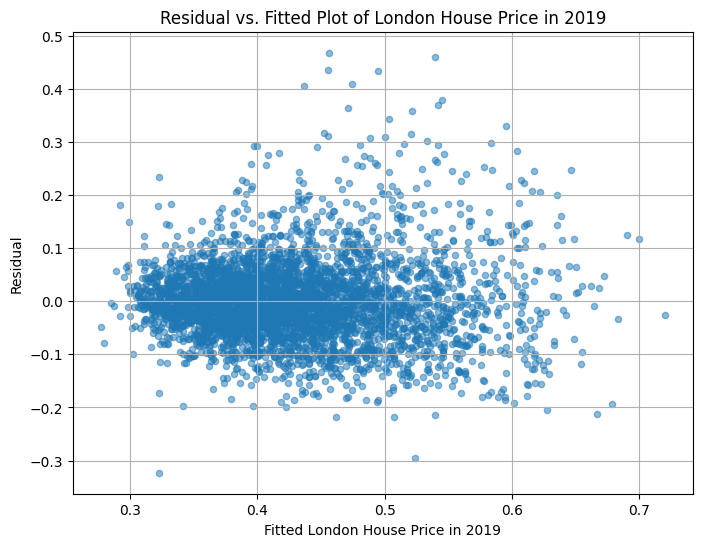

In [141]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(model3.fittedvalues, model3.resid, alpha = 0.5, s=20)
# plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted London House Price in 2019')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of London House Price in 2019')
# Adding grid lines
plt.grid(True)
plt.show()